# Time domain
## Peak detection and envelope
### Peak of Peak algorithm
The algorithm first use scipy.signal.find_peaks to detect all the peaks in a signal and perform linear interpolation to obtain an envelope which still preserve the shape of the original signal and the peak location. After getting the envelope, we use scipy.signal.find_peaks to detect the peaks in the envelope and filter the abnormal value to get the time of all peaks.

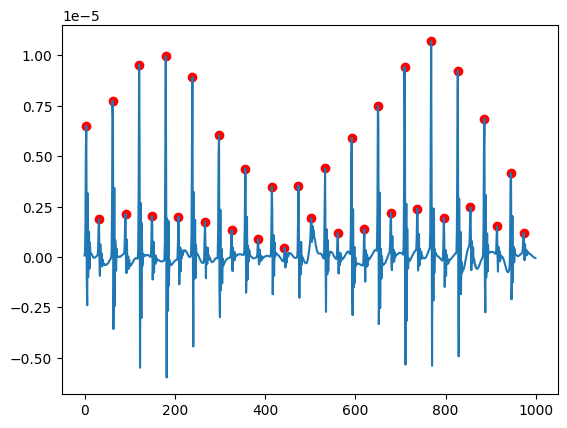

In [17]:
from dsp import get_peaks
import numpy as np
import matplotlib.pyplot as plt

signal = np.load("./data/sim_100_0.1_90_140_train.npy")[1,:1000]
peaks = get_peaks(signal)
plt.plot(signal)
plt.scatter(peaks,signal[peaks],c="red")
plt.show()

### Envelope from peaks
We can use the first step of peak of peak algorithm as a kind of envelope generation algorithm. We can perform linear interpolation of all peaks to obtain an envelope.

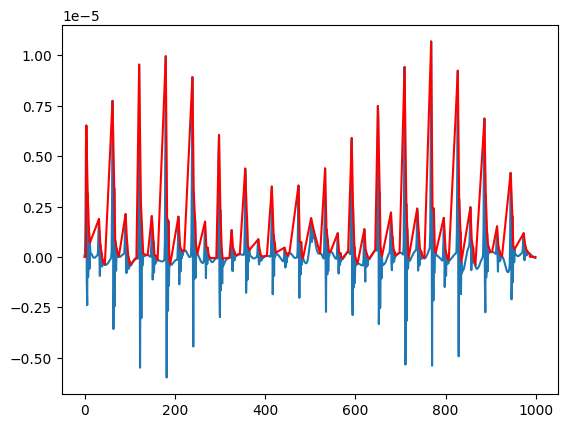

In [2]:
from dsp import envelope_from_peaks
import numpy as np
import matplotlib.pyplot as plt

signal = np.load("./data/sim_100_0.1_90_140_train.npy")[1,:1000]
envelope = envelope_from_peaks(signal)
plt.plot(signal)
plt.plot(envelope,c="red")
plt.show()

### Average_envelope
We can also use the average window to get the envelope. The average window will calculate the average value of a region to replace the middle timestamp in the region. The longer the window, the smoother the envelope, but the more serious it will change the shape of the original signal.
$$
    envelope[i]~=~signal[i-\frac{window\_length}{2}]~+~....~+~signal[i]~+~....~+~signal[i+\frac{window\_length}{2}]
$$

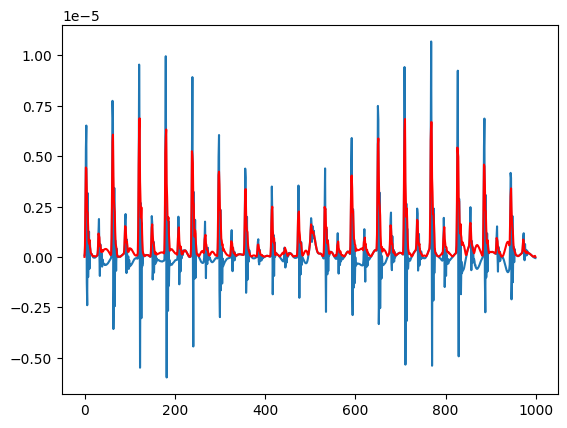

In [13]:
from dsp import average_envelope
import numpy as np
import matplotlib.pyplot as plt

signal = np.load("./data/sim_100_0.1_90_140_train.npy")[1,:1000]
envelope = average_envelope(signal, 3)
plt.plot(signal)
plt.plot(envelope,c="red")
plt.show()

## Analytic Signal and Hilbert Transformation

Fourier Transform of a real-valued signal is complex-symmetric whose negative frequencies are redundant with respect to the positive frequencies. To remove the redundancy, the analytic signal is invented. It is complex-valued but its spectrum will be one-sided (only positive frequencies) that preserved the spectral content of the original real-valued signal. Using an analytic signal instead of the original real-valued signal, is useful in many signal processing applications. For example, in spectral analysis, use of analytic signal in-lieu of the original real-valued signal mitigates estimation biases and eliminates cross-term artifacts due to negative and positive frequency components.

In the frequency domain, the analytic signal has only the postive part of the original signal and the magnitude is two times of the orignal postive spectrum. In the time domain, the real part of the analytic signal is the same as the original signal, but it has a imaginary part. $z(t)$ denotes the time domain analytic singal, and $x(t)$ denotes the original signal.
$$
z(t) = z_{r}(t) + z_{i}(t) = x(t) + z_{i}(t)
$$
So what's the imaginary part? Hilbert Transformation can be used to find the imaginary part of the orignal real-valude signal.
$$
z(t) = z_{r}(t) + z_{i}(t) = x(t) + jHT\{x(t)\}
$$
$$
HT\{x(t)\} = x(t) * \frac{1}{\pi t} \longleftrightarrow F(f)[-jsgn(f)] = \begin{cases}-jF(f) & f > 0 \\ jF(f) & f< 0 \end{cases}
$$
We can take the hilbert transformation as a filter whose impulse response is $\frac{1}{\pi t}$. And the HT\{x(t)\} has some properties.
1. HT\{HT\{x(t)\}\} = -x(t)
2. HT\{x(t)\} has the opposite parity of x(t)
3. HT\{x(t)\} and x(t) are orthogonal

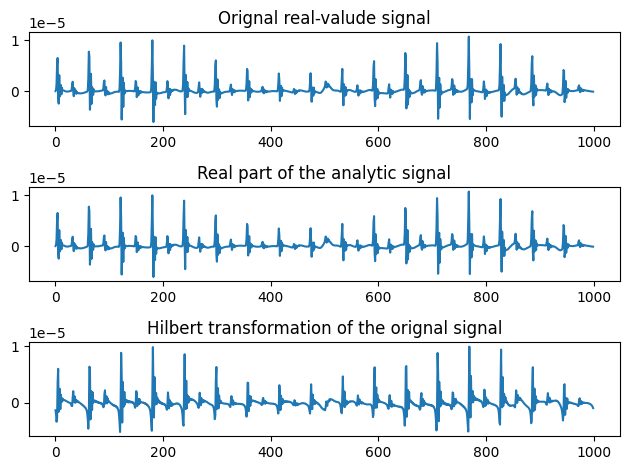

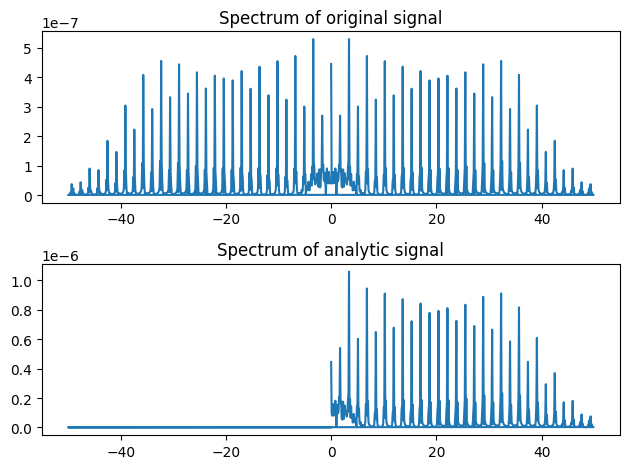

In [7]:
import numpy as np
from matplotlib import pyplot as plt
from dsp import analytic_signal, hilbert_transform

signal = np.load("./data/sim_100_0.1_90_140_train.npy")[1,:1000]
z = analytic_signal(signal)

fig, axis = plt.subplots(3,1)
axis[0].set_title("Orignal real-valude signal")
axis[0].plot(signal)

axis[1].set_title("Real part of the analytic signal")
axis[1].plot(z.real)

axis[2].set_title("Hilbert transformation of the orignal signal")
axis[2].plot(hilbert_transform(signal))
plt.tight_layout()
plt.show()

freq_original, mag_original = my_fft(signal, 100)
freq_analytic, mag_analytic = my_fft(z, 100)

fig, axis = plt.subplots(2,1)
axis[0].set_title("Spectrum of original signal")
axis[0].plot(freq_original, np.abs(mag_original))

axis[1].set_title("Spectrum of analytic signal")
axis[1].plot(freq_analytic, np.abs(mag_analytic))

plt.tight_layout()
plt.show()

## Extract envelope, phase using Hilbert transform

If a modulated signal is expressed as $x(t) = a(t) cos[ \phi (t)]$

The instantaneous amplitude or the envelope of the signal is given by $a(t)$

The instantaneous phase is given by  $\phi(t)$

The instantaneous angular frequency is derived as $\omega(t) = \frac{d}{dt} \phi(t)$

The instantaneous temporal frequency is derived as $f(t) = \frac{1}{2 \pi} \frac{d}{dt} \phi(t)$

We note that the modulated signal is a real-valued signal. We also take note of the fact that amplitude/phase and frequency can be easily computed if the signal is expressed in complex form. So we can use Hilbert transformation to transform the real-valued signal to a complex version.

The analytic signal is 
$$
z(t) = z_{r}(t) + z_{i}(t) = x(t) + jHT\{x(t)\}
$$
So
$$
a(t) = |z(t)| = \sqrt{z_r^2(t) + z_i^2(t)} 
$$
$$
\phi(t) = \angle z(t) = arctan \left[ \frac{z_i(t)}{z_r(t)} \right] 
$$
$$
f(t) = \frac{1}{2 \pi} \frac{d}{dt} \phi(t) 
$$

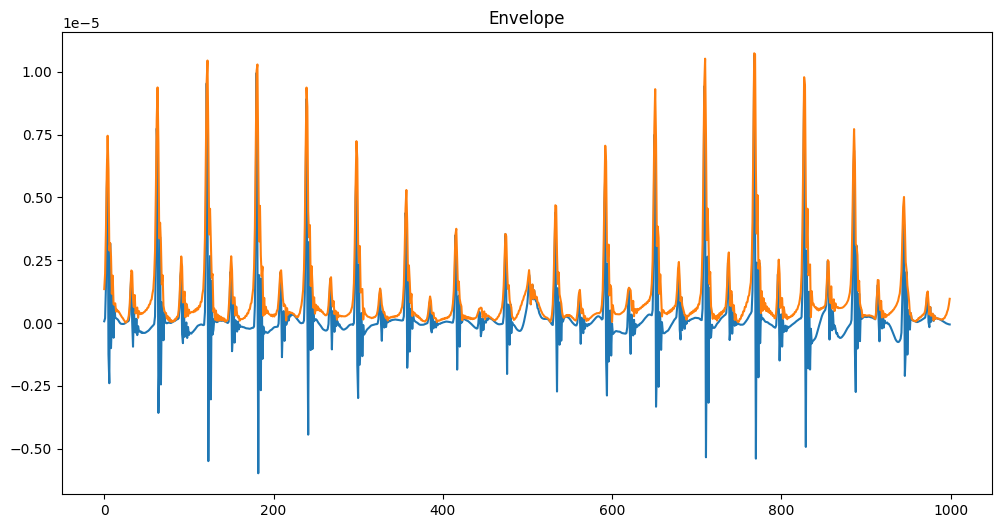

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dsp import inst_amplitude, inst_phase, inst_freq

signal = np.load("./data/sim_100_0.1_90_140_train.npy")[1,:1000]

plt.figure(figsize=(12, 6))
plt.title("Envelope")
plt.plot(signal)
plt.plot(inst_amplitude(signal))
plt.show()

## Singular Spectrum Transformation (SST)

SST is a signal processing technique based on singular spectrum analysis, used for extracting trends and periodic components in a signal. SST is primarily employed for decomposing signals and reconstructing their components to better understand the structure and features of the signal.

The main steps of SST include:

1. **Embedding**:
   Convert the original signal into matrix form. This often involves creating a Hankel matrix where rows and columns consist of subsequences of the original signal. This embedding process helps capture local structures in the signal.

2. **Singular Value Decomposition (SVD)**:
   Perform singular value decomposition on the embedded matrix, breaking it down into three matrices: U, Σ, and V^T. Here, U contains the left singular vectors, Σ contains the singular values in a diagonal matrix, and V^T contains the right singular vectors.

3. **Grouping and Reconstruction**:
   Group the singular values based on their magnitudes into several subsequences. These subsequences correspond to different frequency and trend components of the signal. By selecting relevant combinations of singular values, different components of the original signal can be reconstructed.

4. **Back-Transformation**:
   Perform the inverse transformation on the decomposed subsequences to obtain an estimate of the original signal. This step involves reversing the embedding operation on the reconstructed subsequences.

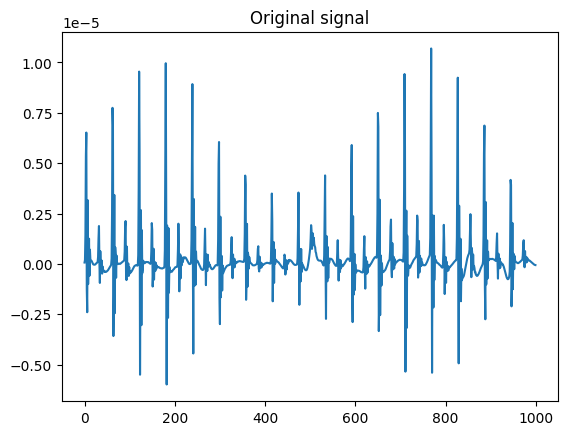

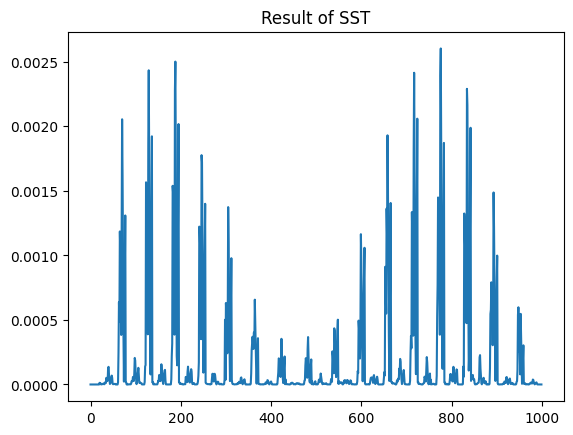

In [6]:
from dsp import SingularSpectrumTransformation
import numpy as np
import matplotlib.pyplot as plt

signal = np.load("./data/sim_100_0.1_90_140_train.npy")[1,:1000]

sst = SingularSpectrumTransformation(win_length=8)
score = sst.score_offline(signal)

plt.title("Original signal")
plt.plot(signal)
plt.show()

plt.title("Result of SST")
plt.plot(score)
plt.show()

## Petrosian Fractal Dimension (PFD)

Petrosian Fractal Dimension (PFD) is a method used to measure the complexity of time-series signals, particularly applicable in biomedical signals such as electrocardiograms (ECG). It calculates the fractal dimension of a signal to describe its complexity and irregularity. A higher Petrosian Fractal Dimension value indicates a more complex signal.
$$
PFD = \frac{\log_{10}(N)}{\log_{10}(N) + \log_{10}\left(\frac{N}{N + 0.4N_{\text{zc}}}\right)}
$$
where $N$ is the length of the signal and $N_{zc}$ is the number of zero crossings in the signal derivative..

In [8]:
import numpy as np
from dsp import get_template, pfd
import matplotlib.pyplot as plt

signal = np.load("./data/sim_100_0.1_90_140_train.npy")[1,:1000]
template = get_template(signal)

print(pfd(template))

1.0352987947182408


# Frequency domain
## FFT

A fast algorithm to calculate the DFT

$$
X[k] = \sum_{n=0}^{N-1}x[n]e^{-j2\pi kn/N}
$$
$$
x[n] = \frac{1}{2\pi}\sum_{k=0}^{N-1}X[k]e^{j2\pi kn/N}
$$
$my\_fft$ gets the original signal and the sampling rate as input and outputs the frequency and corresponding mag which is a complex number. The length of the frequency is the half of the fs.

$my\_ifft$ gets the mag of the $my\_fft$ as input and outputs the original signal.

The basic function of the fft is orthogonal. Why orthogonal is important? Because it can help us determine the cofficient conveniently. We can only multiple the signal and the basic function to get the cofficient of the basic funtion.

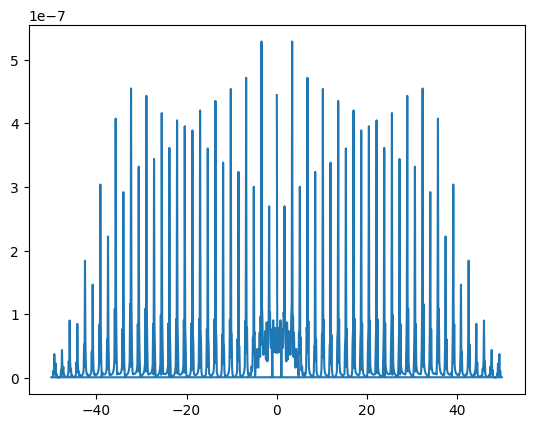

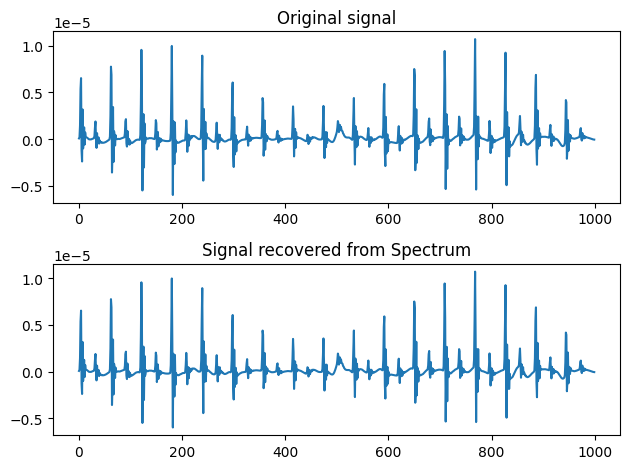

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from dsp import my_fft, my_ifft

signal = np.load("./data/sim_100_0.1_90_140_train.npy")[1,:1000]
fs = 100

freq, mag = my_fft(signal, fs)
plt.plot(freq, np.abs(mag))
plt.show()

signal_recovered = my_ifft(mag)

fig, axis = plt.subplots(2,1)
axis[0].set_title("Original signal")
axis[0].plot(signal)

axis[1].set_title("Signal recovered from Spectrum")
axis[1].plot(signal_recovered.real)
plt.tight_layout()
plt.show()

## Power Spectral Density (PSD)
It is a tool used for frequency spectrum analysis to describe how the power of a signal varies with frequency.

The PSD represents the distribution of power across different frequencies in a signal, typically measured in power per Hertz (Hz). It can be computed by taking the squared magnitude of the Fourier transform of the signal. Specifically, for a time-domain signal x(t), the Power Spectral Density $S_{xx}(f)$ at frequency $f$ is calculated as:
$$
S_{xx}(f) = \lim_{{T \to \infty}} \frac{1}{T} \left| \int_{-T/2}^{T/2} x(t) e^{-j 2 \pi f t} \,dt \right|^2 
$$

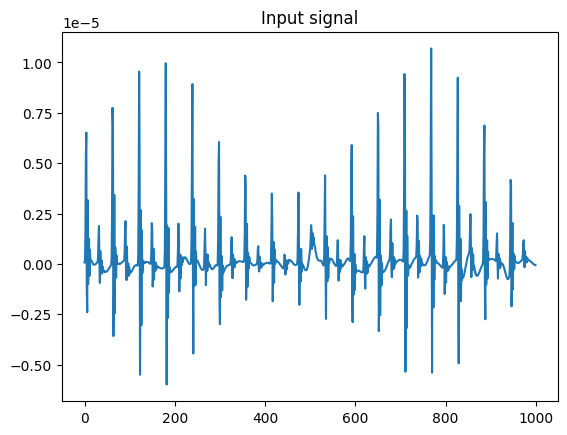

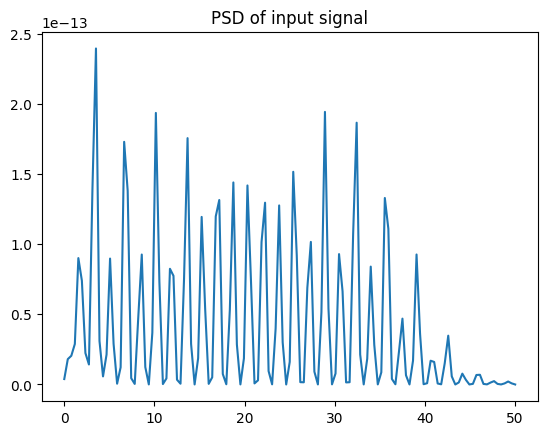

In [1]:
import numpy as np
from dsp import extract_power_spectral_density
import matplotlib.pyplot as plt

fs = 100
signal = np.load("./data/sim_100_0.1_90_140_train.npy")[1,:1000]
f,p = extract_power_spectral_density(signal, fs)

plt.title("Input signal")
plt.plot(signal)
plt.show()

plt.title("PSD of input signal")
plt.plot(f,p)
plt.show()

# Time-Frequency domain
## Short Time Fourier Transformation (STFT)

To get the time information of the signal, we segment the signal and view the signal in the segment as stationary signal. However, when the signal does not complete an integer number of cycles, an issue known as Frequency Leakage may occur which can pose challenges in reconstructing the original signal based on the spectrum. To minimize the impact of Frequency Leakage, the original signal can be multiplied by a window function. After framing, we get many framed segment. Then we do the DFT to get frequency information of each frame. The scale of y axis is frequency. Then we concatenate the spectrum horizontally to get the spectrogram. The spectrogram has both the frequency and time frequency of a signal.

The longer the frame, the frequency information is more accurate, the time information is less accurate. The above is what we call heisenberg uncertainty principle.

The output of the stft is y-axis (frequency), x-axis (time) and the value of each point (magnitude). The max number of y-axis (frequency) is the half of the fs which is based on the Nyquist sampling princple, but the number of frequency in y-axis is the half of the nperseg. The number of the x-axis depends on the nperseg and the noverlap and the max number of the x-axis is (length of signal / fs). The output Z is complex-valued.

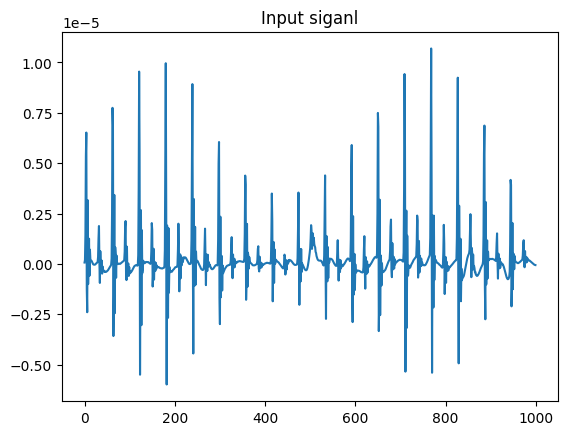

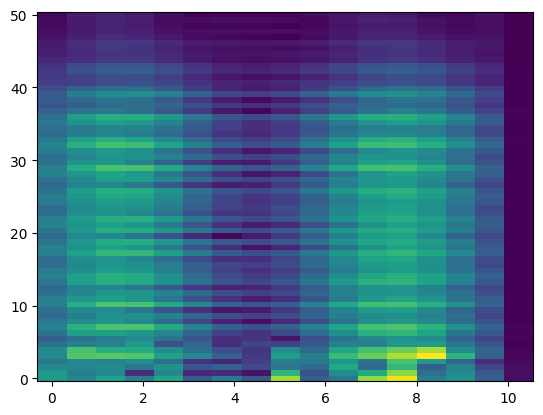

In [2]:
import numpy as np
from dsp import my_stft
import matplotlib.pyplot as plt


signal = np.load("./data/sim_100_0.1_90_140_train.npy")[1,:1000]
plt.title("Input siganl")
plt.plot(signal)
plt.show()


fs = 100 # sampling frequency
window = 'hann' # window type
nperseg = 128 # length of frame

# STFT
f, t, Z = my_stft(signal, plot=True, fs=fs, window=window, nperseg=nperseg)

## Wavelet analysis

STFT has a serious problem, that is we can't get a good time and frequency resolution. The bigger the nperseg, the better the frequency resolution, but the worse time resolution, vice versa. The above problem is caused by the fact that the nperseg is fixed. So we introduce the wavelet analysis which is a MRA method. MRA (multiresolution analysis) is designed to give good time resolution and poor frequency resolution at high frequencies and good frequency resolution and poor time resolution at low frequencies.Generally, the basic function of wavelet transform is orthogonal and normalized (normalized makes the transformed signal have the same energy at every scale).

### Mexican Hat wavelet

It is the second derivative of the Gaussian function.

Gaussian function:
$$
w(t) = \frac{1}{\sqrt{2\pi} \cdot \sigma} e^{\frac{-t^2}{2 \sigma^2}}
$$

Second derivative of the Gaussian function:
$$
\psi(t) = \frac{1}{\sqrt{2 \pi} \cdot \sigma^3} \left( e^{\frac{-t^2}{2 \sigma^2}} \cdot \left( \frac{t^2}{\sigma^2} - 1 \right) \right)
$$

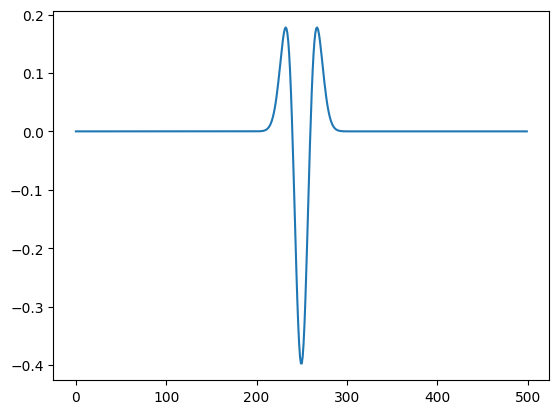

In [3]:
import matplotlib.pyplot as plt
from dsp import mexican_hat_wavelet

sigma = 1
length = 50
psi = mexican_hat_wavelet(sigma, length)
plt.plot(psi)
plt.show()

### Morlet wavelet 

It is defined as follows:
$$
w(t) = e^{i a t} \cdot e^{-\frac{t^2}{2\sigma}}
$$

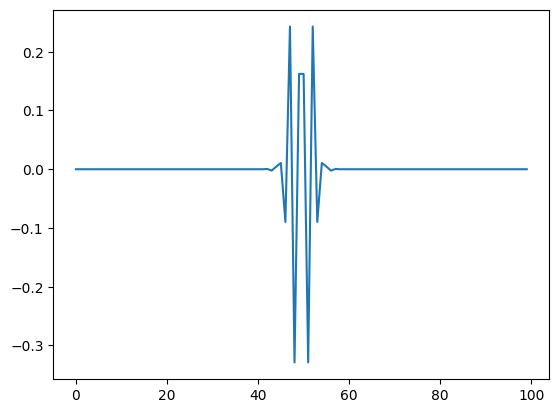

In [3]:
import matplotlib.pyplot as plt
from dsp import morlet_wavelet

length = 100
sigma = 2
a = 5
omega = morlet_wavelet(length, sigma, a)
plt.plot(omega.real)
plt.show()

## Continues Wavelet Transform （CWT）

In CWT, the signal can be transformed by:

$$
CWT_x^\psi(\tau,s) = \Psi_x^\psi(\tau,s) = \frac{1}{\sqrt{|s|}} \int x(t) \psi^* \left( \frac{t - \tau}{s} \right) dt
$$

where the $\tau$ and $s$ are incremented continuously. However, if this transform needs to be computed by a computer, then both parameters are increased by a sufficiently small step size. This corresponds to sampling the time-scale plane.

## Inverse CWT

$$
x(t)=\frac{1}{c_{\psi}^{2}} \int_{s} \int_{\tau} \Psi_{x}^{\psi}(\tau, s) \frac{1}{s^{2}} \psi\left(\frac{t-\tau}{s}\right) d \tau d s
$$

where \c_{\psi} is a constant that depends on the wavelet used. It can be calculated as follows:
$$
c_{\psi}=\left\{2 \pi \int_{-\infty}^{\infty} \frac{|\hat{\psi}(\xi)|^{2}}{|\xi|} d \xi\right\}^{1 / 2}
$$

where $\hat{\psi(\xi)}$ is the FT of $\psi(t)$

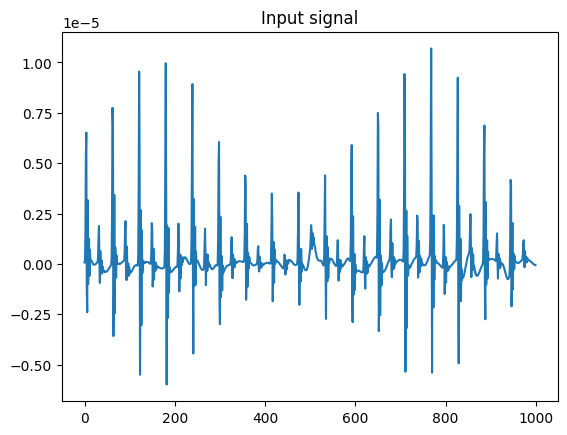

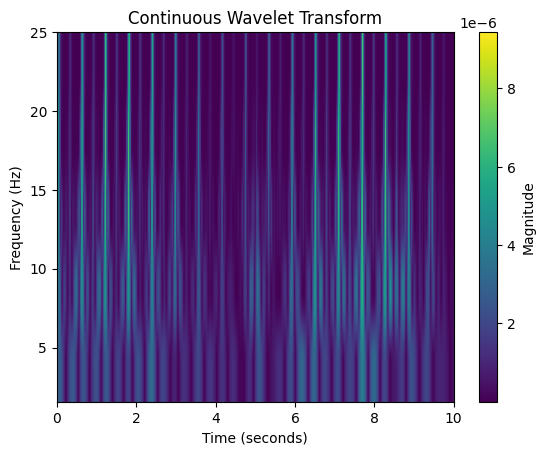

In [3]:
from dsp import my_cwt
import numpy as np
import matplotlib.pyplot as plt
    
fs = 100
signal = np.load("./data/sim_100_0.1_90_140_train.npy")[1,:1000]
plt.title("Input signal")
plt.plot(signal)
plt.show()

scales = np.array([1,2,4,8,16])  
wavelet = 'mexh' 

coefficients, frequencies = my_cwt(signal, scales, wavelet, fs, True)

## Polynomial Chirplet Transform (PCT)
PCT is a signal processing technique and a variant of the Chirplet Transform. The Chirplet Transform is a method used to analyze non-stationary modulations in signals, and PCT further introduces polynomial functions to enhance its analytical capabilities.

In the Chirplet Transform, "Chirp" refers to a signal with a frequency that varies over time, and a "Chirplet" is a wavelet associated with a Chirp. PCT introduces polynomial modulation functions, allowing the frequency, phase, and amplitude of Chirplets to vary according to the shape of the polynomial.

The core idea of PCT is to use polynomials to describe the nonlinear modulation characteristics of a signal, thereby better capturing the complex structures and non-stationary nature of the signal. This method is effective for analyzing signals where frequency, phase, and amplitude change over time.

### Chirplet Transform:

The Chirplet Transform of a signal $x(t)$ is often represented as:
$$
C(a, b, \omega, \tau) = \int_{-\infty}^{\infty} x(t) \psi_{a, b, \omega, \tau}^*(t) \, dt
$$
where $\psi_{a, b, \omega, \tau}(t)$ is the Chirplet defined as:
$$
\psi_{a, b, \omega, \tau}(t) = e^{j(\omega t + \frac{a}{2}t^2 + b t + \tau)}
$$
### Polynomial Chirplet Transform:

The Polynomial Chirplet Transform extends the Chirplet Transform by introducing a polynomial modulation. The general form is:
$$
C(a, b, \omega, \tau, P(t)) = \int_{-\infty}^{\infty} x(t) \psi_{a, b, \omega, \tau, P(t)}^*(t) \, dt
$$
Here, $P(t)$ is a polynomial function that modulates the Chirplet parameters.
$$
\psi_{a, b, \omega, \tau, P(t)}(t) = e^{j(\omega t + \frac{a}{2}t^2 + b t + \tau + P(t))} 
$$

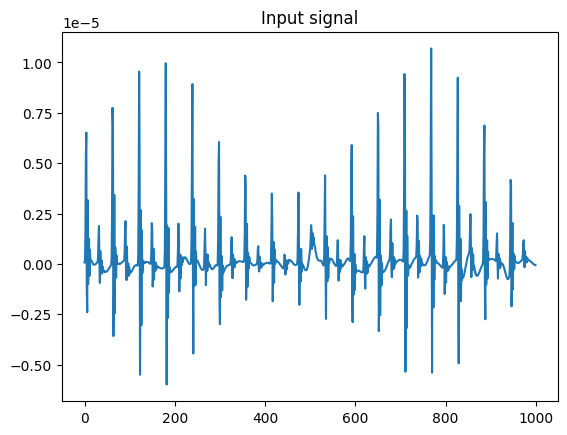

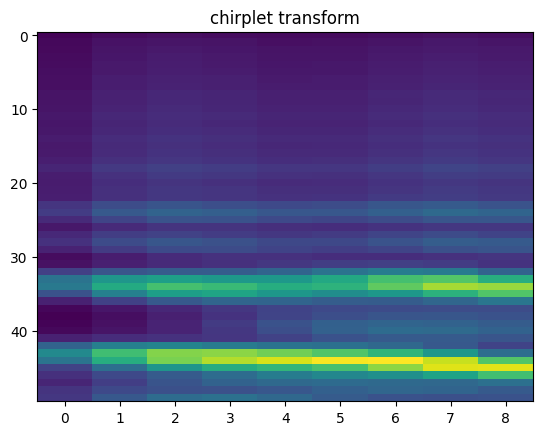

In [1]:
import numpy as np
from dsp import chirplet_transform
import matplotlib.pyplot as plt
    
signal = np.load("./data/sim_100_0.1_90_140_train.npy")[1,:1000]
plt.title("Input signal")
plt.plot(signal)
plt.show()

ct_matrix = chirplet_transform(signal, show=True)

## Wigner Ville Distribution (WVD)


WVD is a time-frequency representation method widely used in signal processing and analysis. The primary goal of the Wigner-Ville Distribution is to provide a representation of the instantaneous frequency distribution of a signal. Unlike traditional methods such as Fourier transform and short-time Fourier transform, the Wigner-Ville Distribution offers more detailed information in both time and frequency domains, simultaneously depicting the variations of a signal over time and frequency.

The definition of WVD is as follows:
$$
W_x(t, f) = \int_{-\infty}^{\infty} x\left(t + \frac{\tau}{2}\right) \cdot \overline{x\left(t - \frac{\tau}{2}\right)} \cdot e^{-2\pi i f \tau} \,d\tau
$$
Here, \(W_x(t, f)\) represents the WVD, \(x(t)\) is the input signal, \(\overline{x(t)}\) denotes the complex conjugate of \(x(t)\), \(t\) is time, and \(f\) is frequency. The WVD describes the transient characteristics of a signal by computing the autocorrelation of the signal at different time windows.

The advantages of WVD include its adaptability to non-stationary signals and its ability to capture the transient features of a signal. However, WVD also has some drawbacks, such as the presence of cross terms that may introduce additional complexity to the analysis.

C:\Users\darcy\Desktop\PHD\Tutorial\dsp.py:1192: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  _, s, _ = np.linalg.svd(U_test[:, :n_components].T @
C:\Users\darcy\anaconda3\envs\pytorch\lib\site-packages\numba\core\typing\npydecl.py:913: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


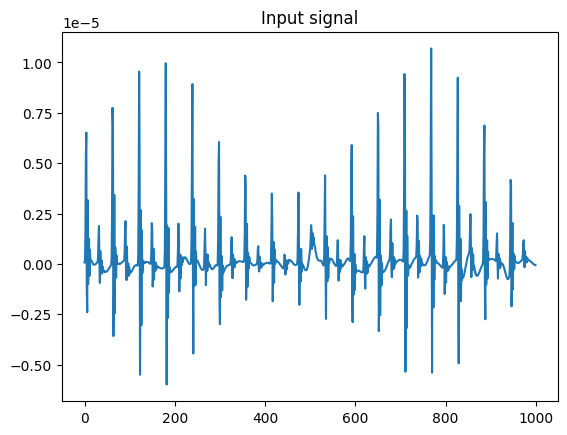

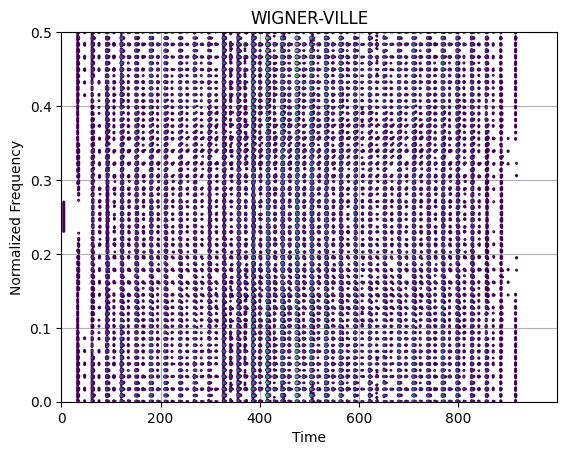

In [1]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import tftb
from dsp import my_wvd


signal = np.load("./data/sim_100_0.1_90_140_train.npy")[1,:1000]
plt.title("Input signal")
plt.plot(signal)
plt.show()

matrix, t, f = my_wvd(signal, show=True)

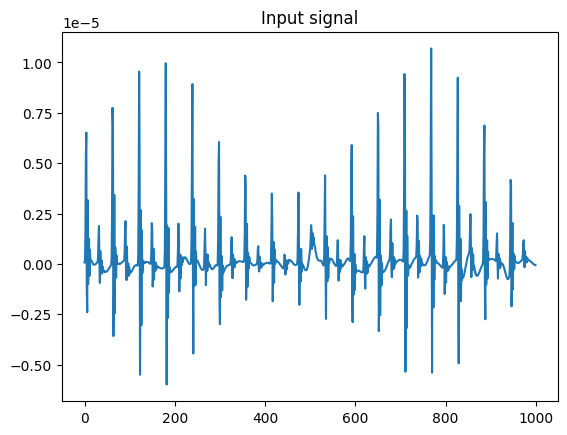

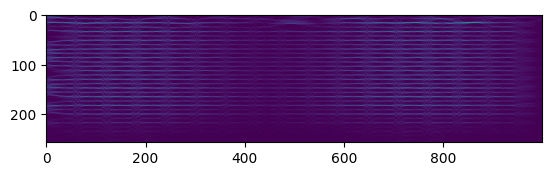

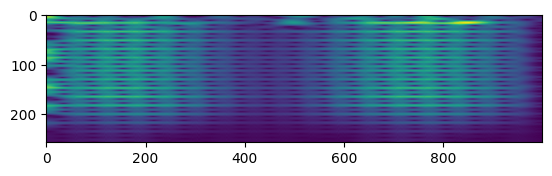

In [24]:
import ssqueezepy as sq
import numpy as np
import matplotlib.pyplot as plt


fs = 100
signal = np.load("./data/sim_100_0.1_90_140_train.npy")[1,:1000]
plt.title("Input signal")
plt.plot(signal)
plt.show()

Tx, Sx, ssq_freqs, Sfs= sq.ssq_stft(signal, window="ham", win_len = 128, fs = fs)
plt.imshow(np.abs(Tx))
plt.show()
plt.imshow(np.abs(Sx))
plt.show()

In [16]:
import ssqueezepy as sq
help(sq.ssq_stft)

Help on function ssq_stft in module ssqueezepy._ssq_stft:

ssq_stft(x, window=None, n_fft=None, win_len=None, hop_len=1, fs=None, t=None, modulated=True, ssq_freqs=None, padtype='reflect', squeezing='sum', gamma=None, preserve_transform=None, dtype=None, astensor=True, flipud=False, get_w=False, get_dWx=False)
    Synchrosqueezed Short-Time Fourier Transform.
    Implements the algorithm described in Sec. III of [1].
    
    MATLAB docs: https://www.mathworks.com/help/signal/ref/fsst.html
    
    # Arguments:
        x: np.ndarray
            Input vector(s), 1D or 2D. See `help(cwt)`.
    
        window, n_fft, win_len, hop_len, fs, t, padtype, modulated
            See `help(stft)`.
    
        ssq_freqs, squeezing
            See `help(ssqueezing.ssqueeze)`.
            `ssq_freqs`, if array, must be linearly distributed.
    
        gamma: float / None
            See `help(ssqueezepy.ssq_cwt)`.
    
        preserve_transform: bool (default True)
            Whether to return